In [177]:
import GEOparse
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns    
import scipy                                     


In [178]:
gse = GEOparse.get_GEO("GSE4271", destdir="data/",silent=True)

In [ ]:
expression_df = gse.pivot_samples('VALUE') # Some values in the thousands, apply log2 transformation
expression_df = np.log2(expression_df + 1.0)


meta = []
for gsm_name, gsm in gse.gsms.items():
    characteristics = gsm.metadata.get('characteristics_ch1', [])
    char_dict = {}
    for entry in characteristics:
        if ":" in entry:
            key, value = entry.split(":", 1)
            char_dict[key.strip()] = value.strip()   
    char_dict["sample"] = gsm_name
    char_dict["title"] = gsm.metadata.get("title", [""])[0]
    char_dict["source_name"] = gsm.metadata.get("source_name_ch1", [""])[0]
    meta.append(char_dict)
    
    
meta_df = pd.DataFrame(meta).set_index('sample')

# Getting indexes of primary and recurrent samples from metadata

primary_samples = meta_df[meta_df['specimen type'] == 'primary'].index
recurrent_samples = meta_df[meta_df['specimen type'] == 'recurrent'].index

#Create expression dataframes for primary and recurrent samples
primary_expression = expression_df[primary_samples]
recurrent_expression = expression_df[recurrent_samples]



print("Primary samples shape:", primary_expression.shape)


Primary samples shape: (44760, 154)


In [180]:
gpl1 = gse.gpls['GPL96']
gpl2 = gse.gpls['GPL97']
gene_id1 = gpl1.table[['ID', 'Gene Symbol']]
gene_id2 = gpl2.table[['ID', 'Gene Symbol']]

# Combine gene annotation from both platforms
gene_id = pd.concat([gene_id1, gene_id2], axis=0)
gene_id = gene_id.rename(columns={"ID":"ID_REF"}).set_index("ID_REF")

print(gene_id)


                      Gene Symbol
ID_REF                           
1007_s_at        DDR1 /// MIR4640
1053_at                      RFC2
117_at                      HSPA6
121_at                       PAX8
1255_g_at                  GUCA1A
...                           ...
AFFX-ThrX-5_at                NaN
AFFX-ThrX-M_at                NaN
AFFX-TrpnX-3_at               NaN
AFFX-TrpnX-5_at               NaN
AFFX-TrpnX-M_at               NaN

[44928 rows x 1 columns]


In [187]:
primary_expression = expression_df[primary_samples]
recurrent_expression = expression_df[recurrent_samples]

# Map probe IDs to gene symbols
primary_expression = primary_expression.merge(gene_id, left_index=True, right_index=True)
primary_expression = primary_expression.set_index('Gene Symbol')
print("After merging gene symbols, primary samples shape:", primary_expression.shape)

recurrent_expression = recurrent_expression.merge(gene_id, left_index=True, right_index=True)
recurrent_expression = recurrent_expression.set_index('Gene Symbol')
print("After merging gene symbols, recurrent samples shape:", recurrent_expression.shape)


After merging gene symbols, primary samples shape: (44928, 154)
After merging gene symbols, recurrent samples shape: (44928, 46)


In [182]:
mean_df = pd.DataFrame()
mean_df['Primary Mean'] = primary_expression.mean(axis=1)
mean_df['Recurrent Mean'] = recurrent_expression.mean(axis=1)
print(mean_df.head())

                  Primary Mean  Recurrent Mean
Gene Symbol                                   
DDR1 /// MIR4640     12.220744       12.108240
RFC2                  8.272746        8.601133
HSPA6                 7.463150        7.358438
PAX8                  9.878510        9.820814
GUCA1A                6.042537        5.787569


In [183]:

from scipy import stats
from statsmodels.stats.multitest import multipletests

# 1) Align genes and aggregate duplicate probes by mean
common_genes = primary_expression.index.intersection(recurrent_expression.index)
prim = primary_expression.loc[common_genes].copy()
rec = recurrent_expression.loc[common_genes].copy()

# If probes map to the same gene symbol, aggregate by mean
if prim.index.duplicated().any():
    prim = prim.groupby(level=0).mean()
if rec.index.duplicated().any():
    rec = rec.groupby(level=0).mean()

# Ensure same ordered index
genes = prim.index.intersection(rec.index)
prim = prim.loc[genes].astype(float)
rec = rec.loc[genes].astype(float)

# 2) Remove genes with any NaN across samples (or impute if you prefer)
na_genes = prim.isna().any(axis=1) | rec.isna().any(axis=1)
print("genes total:", len(genes), "genes with NaN (will be dropped):", na_genes.sum())
prim = prim.loc[~na_genes]
rec = rec.loc[~na_genes]

# 3) Check group sizes
n_prim = prim.shape[1]
n_rec = rec.shape[1]
print("primary samples:", n_prim, "recurrent samples:", n_rec)
if n_prim < 2 or n_rec < 2:
    print("WARNING: <2 samples in a group -> t-test unreliable")

# 4) per-gene t-test (axis=1: each row is a gene)
tt = stats.ttest_ind(rec.values, prim.values, axis=1, equal_var=False, nan_policy='omit')
p_values = tt.pvalue
# replace NaN p-values (e.g., constant values or insufficient data) with 1.0
p_values = np.where(np.isfinite(p_values), p_values, 1.0)

# 5) fold change
fold_changes = rec.mean(axis=1) - prim.mean(axis=1)

# 6) Build dataframe and adjust p-values
volcano_df = pd.DataFrame({
    'log2FC': fold_changes,
    'p-value': p_values
}, index=prim.index)

volcano_df['adj p-value'] = multipletests(volcano_df['p-value'], method='fdr_bh')[1]

print("tested genes:", volcano_df.shape[0])

# Minus log10 p-value for better visualization
volcano_df = volcano_df.dropna(subset=['adj p-value'])
volcano_df['adj -log10 p-value'] = -np.log10(volcano_df['adj p-value'] + 1e-10)
volcano_df['-log10 p-value'] = -np.log10(volcano_df['p-value'] + 1e-10)

print(volcano_df.head())



genes total: 20441 genes with NaN (will be dropped): 16018
primary samples: 154 recurrent samples: 46
tested genes: 4423
               log2FC   p-value  adj p-value  adj -log10 p-value  \
Gene Symbol                                                        
A1CF        -0.025210  0.912054     0.999549            0.000196   
AAGAB       -0.027722  0.851989     0.999549            0.000196   
AAK1        -0.071887  0.782383     0.999549            0.000196   
AASDHPPT    -0.116743  0.792890     0.999549            0.000196   
ABCA5        0.019445  0.944969     0.999549            0.000196   

             -log10 p-value  
Gene Symbol                  
A1CF               0.039979  
AAGAB              0.069566  
AAK1               0.106581  
AASDHPPT           0.100787  
ABCA5              0.024582  


In [188]:
#Create general dataframe

general = volcano_df.copy()
general = general.merge(mean_df, left_index=True, right_index=True)
general.to_csv("data/GSE4271_general_dataframe.csv")

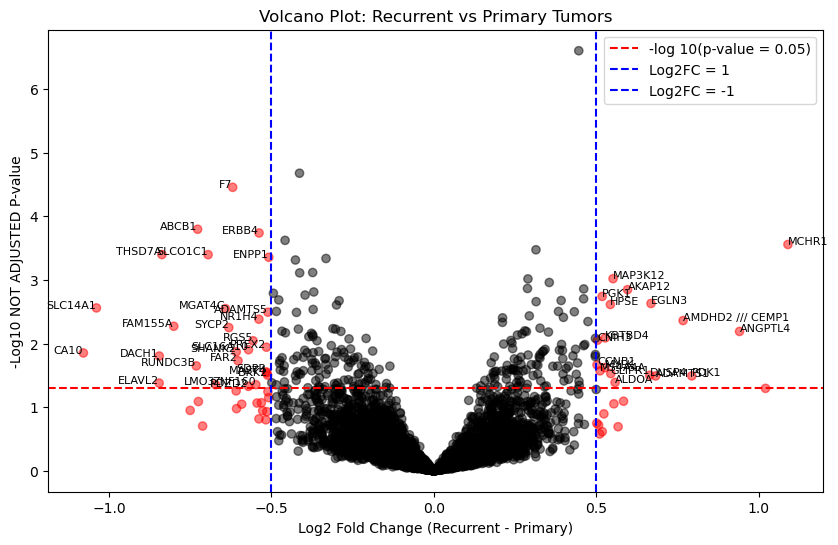

In [185]:
# Plot volcano plot

colors = np.where(abs(volcano_df["log2FC"]) >= 0.5, "red", "black")

plt.figure(figsize=(10, 6))
plt.scatter(volcano_df['log2FC'], volcano_df['-log10 p-value'], alpha=0.5, c=colors)
plt.title('Volcano Plot: Recurrent vs Primary Tumors')

plt.xlabel('Log2 Fold Change (Recurrent - Primary)')
plt.ylabel('-Log10 NOT ADJUSTED P-value')
plt.axhline(y=-np.log10(0.05), color='red', linestyle='--', label='-log 10(p-value = 0.05)')

plt.axvline(x=0.5, color='blue', linestyle='--', label='Log2FC = 1')
plt.axvline(x=-0.5, color='blue', linestyle='--', label='Log2FC = -1')
plt.legend()

# Label genes that are significant and have high fold change
significant = volcano_df[(volcano_df['p-value'] < 0.05) & (abs(volcano_df['log2FC']) >= 0.5)]
for gene in significant.index:
    plt.text(volcano_df.loc[gene, 'log2FC'], volcano_df.loc[gene, '-log10 p-value'], gene,
             fontsize=8, ha='right' if volcano_df.loc[gene, 'log2FC'] < 0 else 'left')
